In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
import json
from pathlib import Path

In [3]:
path_json='D:/ex/최종프로젝트/aihub/감정복합영상/데이터/labels/'
path_img='D:/ex/최종프로젝트/aihub/감정복합영상/데이터/'

In [5]:
with open(path_json+'기쁨_sampled.json') as f:
    data = json.load(f)

In [6]:
df = pd.json_normalize(data)

# 이미지 bbox eda 시작

In [13]:
import random, math

In [8]:
img_dir = Path("D:/ex/최종프로젝트/aihub/감정복합영상/데이터/기쁨")
out_dir = Path("./out_vis_cv2"); out_dir.mkdir(exist_ok=True)
out_dir.mkdir(parents=True, exist_ok=True)

SAMPLE_SIZE = 2
SEED = 42

In [9]:
ANN_KEYS = {
    "A": ("annot_A.boxes.minX","annot_A.boxes.minY","annot_A.boxes.maxX","annot_A.boxes.maxY","annot_A.faceExp"),
    "B": ("annot_B.boxes.minX","annot_B.boxes.minY","annot_B.boxes.maxX","annot_B.boxes.maxY","annot_B.faceExp"),
    "C": ("annot_C.boxes.minX","annot_C.boxes.minY","annot_C.boxes.maxX","annot_C.boxes.maxY","annot_C.faceExp"),
}
COLORS = {"A": (60,60,255), "B": (60,200,60), "C": (255,160,60)}  # BGR!

In [10]:
def clamp(x1,y1,x2,y2,W,H):
    x1 = max(0, min(W-1, int(round(x1))))
    y1 = max(0, min(H-1, int(round(y1))))
    x2 = max(0, min(W-1, int(round(x2))))
    y2 = max(0, min(H-1, int(round(y2))))
    if x2 < x1: x1, x2 = x2, x1
    if y2 < y1: y1, y2 = y2, y1
    return x1,y1,x2,y2

In [14]:
# filename → 해당 row 한 줄 매핑(중복 없다고 가정)
row_map = {row["filename"]: row for _, row in df.iterrows()}

all_imgs = sorted([p for p in img_dir.glob("*.jpg") if p.name in row_map])
sample = random.sample(all_imgs, k=min(35, len(all_imgs)))

In [15]:
drawn, skipped = 0, 0
for p in sample:
    row = row_map[p.name]
    img = cv2.imread(str(p))
    if img is None:
        print("read fail:", p); skipped += 1; continue
    H, W = img.shape[:2]

    drew_any = False
    for tag, (kx1,ky1,kx2,ky2,kexp) in ANN_KEYS.items():
        try:
            x1, y1 = float(row[kx1]), float(row[ky1])
            x2, y2 = float(row[kx2]), float(row[ky2])
        except Exception:
            continue
        if pd.isna(x1) or pd.isna(y1) or pd.isna(x2) or pd.isna(y2):
            continue
        x1,y1,x2,y2 = clamp(x1,y1,x2,y2,W,H)
        if x2-x1 <= 0 or y2-y1 <= 0: 
            continue

        cv2.rectangle(img, (x1,y1), (x2,y2), COLORS[tag], 2)
        label = f"{tag}:{row.get(kexp, '')}"
        cv2.putText(img, label, (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, COLORS[tag], 2, cv2.LINE_AA)
        drew_any = True

    cv2.imwrite(str(out_dir / p.name), img)
    drawn += int(drew_any)

print(f"[DONE] saved {len(sample)} imgs, drawn_on={drawn}, skipped={skipped}, out={out_dir}")

[DONE] saved 35 imgs, drawn_on=35, skipped=0, out=out_vis_cv2


In [18]:
out_dir

WindowsPath('out_vis_cv2')

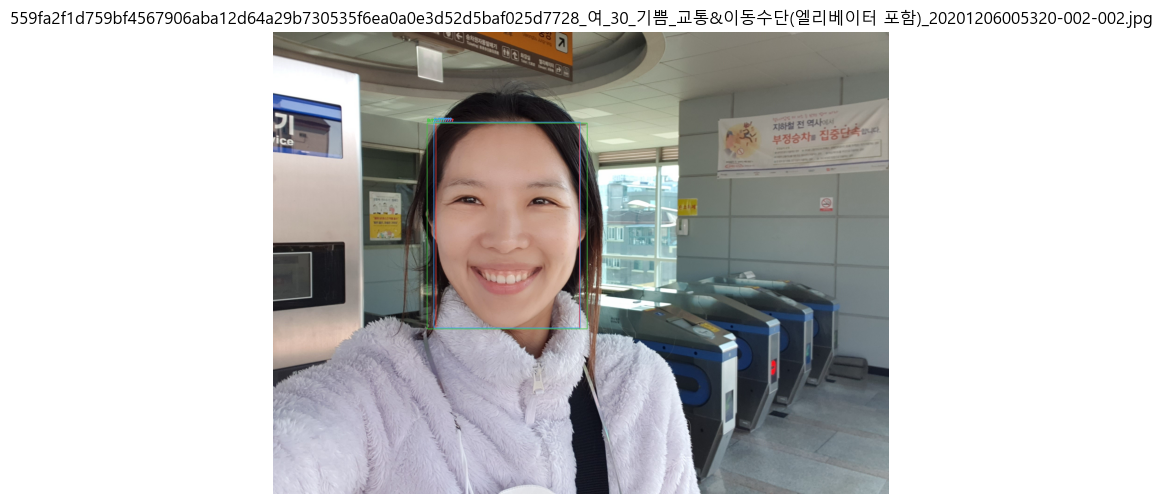

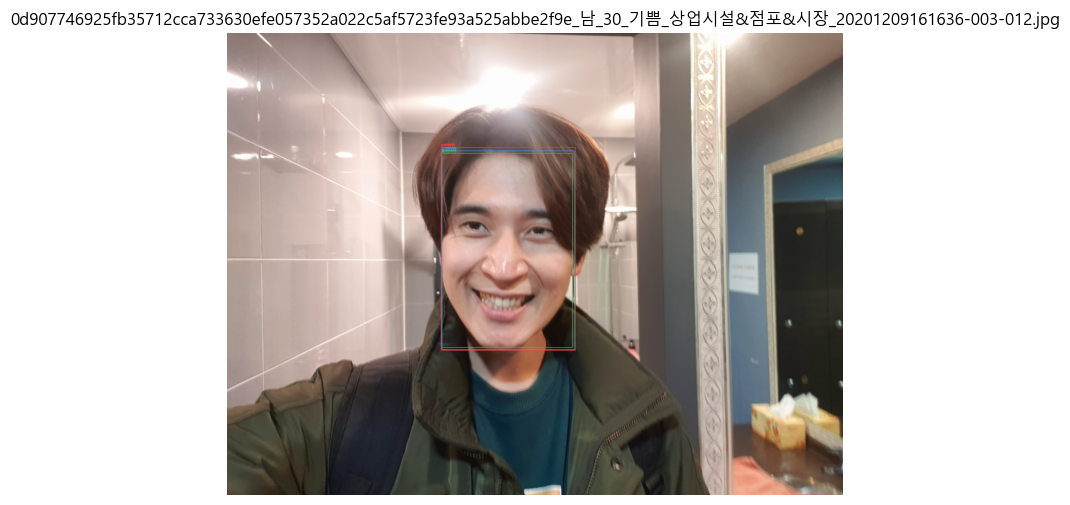

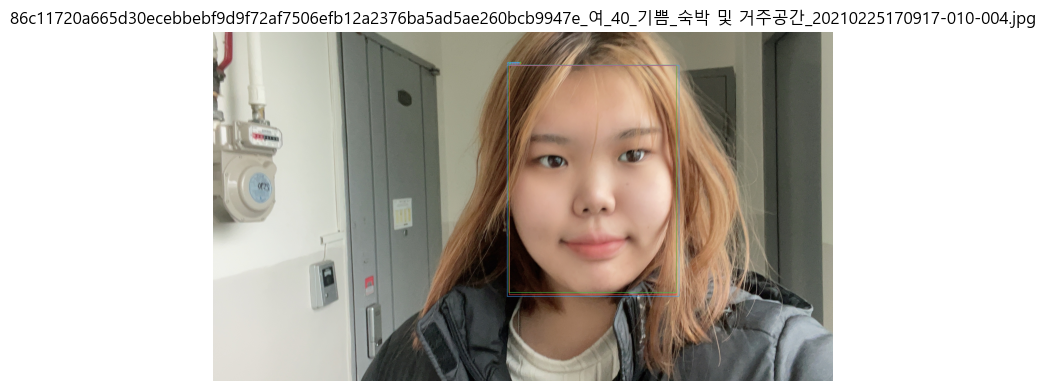

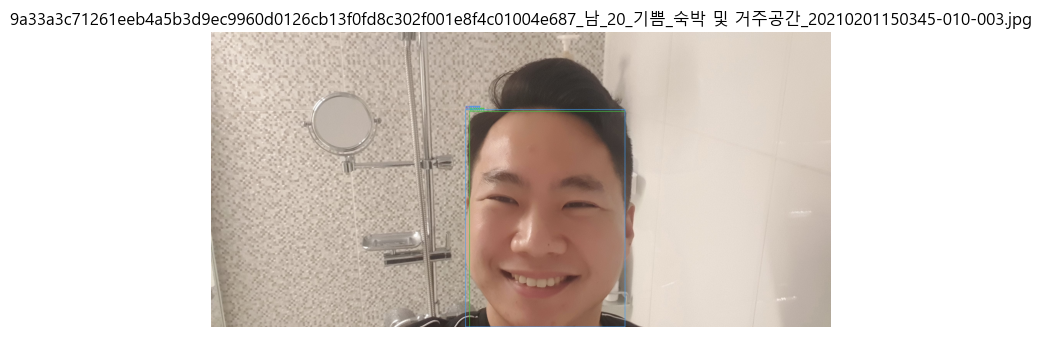

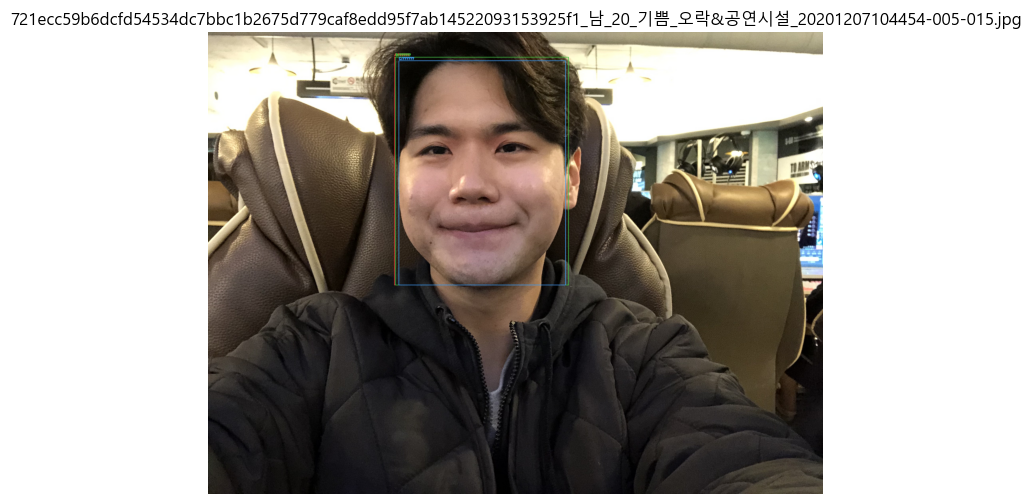

: 

In [ ]:
show_dir = out_dir   # 그려서 저장한 폴더
candidates = sorted(show_dir.glob("*.jpg"))
pick = random.sample(candidates, k=min(5, len(candidates)))  # 5장만

for p in pick:
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img); plt.axis("off"); plt.title(p.name)
    plt.show()